In [ ]:
import brightway2 as bw
import pandas as pd
import numpy as np
from constants import * #constants used in this project

# Choose a project and run LCI

In [ ]:
bw.projects.set_current("SA")

In [ ]:
bw.databases

In [ ]:
db_name = 'ecoinvent 3.5 cutoff'
db = bw.Database(db_name)

In [ ]:
act = db.random()
act_amount = 1.0 #unit demand vector
ipcc2013 = [m for m in bw.methods if 'IPCC' in m[0]
                        and ('2013') in str(m)
                        and 'GWP 100' in str(m)
                        and 'no LT' not in str(m)]
lca = bw.LCA({act:act_amount}, ipcc2013[0])
lca.lci()
lca.lcia()

# EET

## 1. create a vector tech_params identical to lca.tech_params but with an additional column for indices $1,2,...,n_{params}$ and dtype.name $i$

In [ ]:
#augmented dtype
dt = lca.tech_params.dtype.descr
dt.insert(0,('i','<i4'))
dt = np.dtype(dt)

#number of parameters
n_params = lca.tech_params.shape[0]

In [ ]:
#lca.tech_params augmented with the index on the first position
tech_params = np.zeros([n_params],dtype=dt)
i = 0
for x in lca.tech_params:
    temp = list(x)
    temp.insert(0,i)
    tech_params[i] = tuple(temp)
    i += 1

## 2. Generate samples for EET

### Generate uniformly distributed samples ($\in [0,1]$) using SALib or Chris' implementation

In [ ]:
from SALib.sample import morris

In [ ]:
#all uncertain parameters
params = tech_params[tech_params['uncertainty_type']!=ID_NA] #TODO change this eventually
n_vars = len(params)
names  = [str(x) for x in params['i']]
bounds = np.array([np.zeros(n_vars),np.ones(n_vars)]).T #Always [0,1]!
#samples info
n_tra = 500          #number of trajectories
p     = 4           #number of levels, even number recommended
delta = p/(2*(p-1)) #grid jump recommended in papers
#problem
problem = {
    'num_vars':   n_vars,
    'num_levels': p,
    'names':      names,
    'bounds':     bounds,
}

In [ ]:
len(params)

In [1]:
def generate_trajectory_2(num_parameters, levels=4, lower=0, upper=1):
    """
    Generate a trajectory for ``num_parameters``.
    
    Returns an array where the rows are steps in the trajectory, 
    and the columns are coordinates for each parameter. 
    
    The resulting array therefore has dimensions (num_parameters + 1, num_parameters).
    """
    
    pa = np.tile(np.linspace(lower, upper, levels), num_parameters).reshape((num_parameters, levels))
    starting_indices = np.random.randint(0, high=levels - 1, size=num_parameters)
    start = pa[np.arange(num_parameters), starting_indices]
    end = pa[np.arange(num_parameters), starting_indices - int(levels / 2)]
    order = np.random.permutation(np.arange(num_parameters)).reshape((1, -1))
    indices = np.arange(num_parameters + 1).reshape((-1, 1))
    
    start_dense = np.tile(start, num_parameters + 1).reshape((-1, num_parameters))
    end_dense = np.tile(end, num_parameters + 1).reshape((-1, num_parameters))
    
    mask = indices > order
    start_dense[mask] = end_dense[mask]

    return start_dense

In [ ]:
samples2 = np.array([generate_trajectory_2(n_vars, levels=p, lower=0, upper=1) for n in range(n_tra)])
samples2.shape

### Convert uniform samples to original distributions

In [ ]:
from scipy.stats import lognorm, norm, triang

In [ ]:
#give dtype with names to distinguish between input factors
data_type = [('<f4') for x in range(n_vars)]
dt = np.array([names,data_type]).T
dt = [tuple(x) for x in dt]
dt = np.dtype(dt)

samples_dt = np.zeros([N],dtype = dt)
i = 0
for x in samples:
    temp = list(x)
    samples_dt[i] = tuple(temp)
    i = i+1

In [ ]:
def obtain_original_pdf(problem,params,samples_uniform,id_distr):
    
    inds = params[params['uncertainty_type']==id_distr]['i']
    
    if len(inds)<=0:
        return np.zeros(0)
    
    else:
        
        #values corresponding to the chosen distribution
        names = [str(x) for x in inds]
        bounds = problem['bounds']
        p = problem['num_levels']
        
        #variable to save values of the converted distributions
        samples_conv = np.zeros_like(samples_uniform[names])
   
        #lognormal
        if id_distr == ID_LG: 
            
            #Quantiles are the same for all lognormal distributions given the level p
            q_lo = (1-SIX_SIGMA_Q)/2
            q_hi = (1+SIX_SIGMA_Q)/2
            q = np.linspace(q_lo,q_hi,p)
                        
            for name in names:
                
                x = samples_uniform[name]
                i = problem['names'].index(name)
                
                #new distribution
                #in bw:            loc=mu, scale=sigma, where mu and sigma are from the normal distribution
                #in stats.lognorm: loc=shift, s=sigma, scale=exp(mu), where mu and sigma are from the normal distribution 
                input_factor = params[params['i']==int(name)]
                mu = input_factor['loc']
                sigma  = input_factor['scale']
                shift = 0
                
                #generate unique converted values using ppf (=inverse of cdf)
                conv_unique = lognorm.ppf(q,s=sigma,loc=shift,scale=np.exp(mu))
                
                #save converted samples
                x_list = sorted(list(set(x)))
                for i in range(p):
                    samples_conv[name][x==[x_list[i]]] = conv_unique[i]
                                                                                    
        #normal
        elif id_distr == ID_NM:
            
            #Quantiles are the same for all normal distributions given the level p
            q_lo = (1-SIX_SIGMA_Q)/2
            q_hi = (1+SIX_SIGMA_Q)/2
            q = np.linspace(q_lo,q_hi,p)
            
            for name in names:
                
                x = samples_uniform[name]
                i = problem['names'].index(name)
                
                #new distribution
                #in bw:         loc=mu, scale=sigma, where mu and sigma are mean and std
                #in stats.norm: loc=mu, scale=sigma, where mu and sigma are mean and std 
                input_factor = params[params['i']==int(name)]
                mu = input_factor['loc']
                sigma  = input_factor['scale']
                
                #generate unique converted values using ppf (=inverse of cdf)
                conv_unique = norm.ppf(q,loc=mu,scale=sigma)
                
                #save converted samples
                x_list = sorted(list(set(x)))
                for i in range(p):
                    samples_conv[name][x==[x_list[i]]] = conv_unique[i]
                                
        #triangular
        elif id_distr == ID_TR:
            
            q = np.linspace(0,1,p)
            
            for name in names:
            
                x = samples_uniform[name]
                i = problem['names'].index(name)
                
                #new triangular distribution, convert loc, scale and c taken from "bw" to "stats.triang" definition
                #in bw:           input_factor (or params): 'minimum' < loc' < 'maximum'
                #in stats.triang: triangular distribution with an up-sloping line from loc to (loc + c*scale) 
                #                 and then downsloping for (loc + c*scale) to (loc+scale).
                input_factor = params[params['i']==int(name)]
                loc   = input_factor['minimum']
                scale = input_factor['maximum']-input_factor['minimum']
                c     = (input_factor['loc']-loc)/scale
                
                #generate unique converted values using ppf (=inverse of cdf)
                conv_unique = triang.ppf(q,c=c,loc=loc,scale=scale)
                
                #save converted samples
                x_list = sorted(list(set(x)))
                for i in range(p):
                    samples_conv[name][x==[x_list[i]]] = conv_unique[i]
                                    
        return samples_conv

In [ ]:
samples_lg = obtain_original_pdf(problem,params,samples_dt,ID_LG)
samples_nm = obtain_original_pdf(problem,params,samples_dt,ID_NM)
samples_tr = obtain_original_pdf(problem,params,samples_dt,ID_TR)

TODO

think about the computational effort
- how many calculations are needed for a reasonable result?
- how much time is it?

combine samples together and run morris.analyze


### Run Morris

# Tests to estimate computational burden 

## 1. Time wrt trajectories

In [ ]:
import numpy as np
import time
from SALib.sample import morris

n_vars = 50
p = 4
names = [str(i) for i in range(n_vars)]
bounds = np.array([np.zeros(n_vars),np.ones(n_vars)]).T
problem = {
    'num_vars':   n_vars,
    'num_levels': p,
    'names':      names,
    'bounds':     bounds,
}

start = 20
end = 2000
step = 20

t = np.zeros(int((end-start)/step))
num_tra = np.arange(start, end, step)
i = 0
for n_tra in num_tra:
    if i % 200 == 0:
        print(i)
    t1 = time.time()
    samples = morris.sample(problem, n_tra, num_levels=p)  
    t2 = time.time()
    t[i] = t2-t1
    i += 1
    print(i)

In [ ]:
#Fit line
from scipy.optimize import curve_fit

def f(x, A, B, C): # this is your 'straight line' y=f(x)
    return A*x**B + C

A,B,C = curve_fit(f, num_tra, t)[0] 


mycolor1 = (152/256,159/256,189/256)
mycolor2 = (208/256,71/256,40/256)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(num_tra,t,'o',color=mycolor1,markersize=30)
plt.plot(num_tra,f(num_tra,A,B,C),color=mycolor2,lw=20)

plt.tick_params(axis='x',which='both',labelsize=40)
plt.tick_params(axis='y',which='both',labelsize=40)
plt.xlabel('Number of trajectories',fontsize=60)
plt.ylabel('Time, [s]',fontsize=60)
plt.grid(True)

plt.show()

## 2. Time wrt number of parameters

In [ ]:
import numpy as np
import time
from SALib.sample import morris

p = 4
num_tra = 10

start = 10
end = 200
step = 10

num_vars = np.arange(start, end, step)
t = np.zeros(int((end-start)/step))

i = 0
for n_vars in num_vars:
    names = [str(i) for i in range(n_vars)]
    bounds = np.array([np.zeros(n_vars),np.ones(n_vars)]).T

    problem = {
        'num_vars':   n_vars,
        'num_levels': p,
        'names':      names,
        'bounds':     bounds,
    }
    t1 = time.time()
    samples = morris.sample(problem, n_tra, num_levels=p)  
    t2 = time.time()
    t[i] = t2-t1
    i += 1
    print(i)

In [ ]:
#Fit line
from scipy.optimize import curve_fit

def f(x, A, B, C): # this is your 'straight line' y=f(x)
    return A*x**B + C

A,B,C = curve_fit(f, num_vars, t)[0] 


mycolor1 = (152/256,159/256,189/256)
mycolor2 = (208/256,71/256,40/256)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.plot(num_vars,t,'o',color=mycolor1,markersize=30)
plt.plot(num_vars,f(num_vars,A,B,C),color=mycolor2,lw=20)

plt.tick_params(axis='x',which='both',labelsize=40)
plt.tick_params(axis='y',which='both',labelsize=40)
plt.xlabel('Number of input factors',fontsize=60)
plt.ylabel('Time, [s]',fontsize=60)
plt.grid(True)
plt.locator_params(axis='x', nbins=6)

plt.show()

## 3. Time wrt to number of levels

In [16]:
import numpy as np
import time
from SALib.sample import morris

n_vars = 10000
n_tra  = 1

names = [str(i) for i in range(n_vars)]
bounds = np.array([np.zeros(n_vars),np.ones(n_vars)]).T

problem = {
    'num_vars':   n_vars,
    'names':      names,
    'bounds':     bounds,
}

start = 10
end = 1000
step = 10

num_p = np.arange(start, end, step)
t = np.zeros(int((end-start)/step))

i = 0
for p in num_p:
    t1 = time.time()
    #samples = morris.sample(problem, n_tra, num_levels=p)  
    samples = np.array([generate_trajectory_2(n_vars, levels=p, lower=0, upper=1) for n in range(n_tra)])
    t2 = time.time()
    t[i] = t2-t1
    i += 1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


KeyboardInterrupt: 

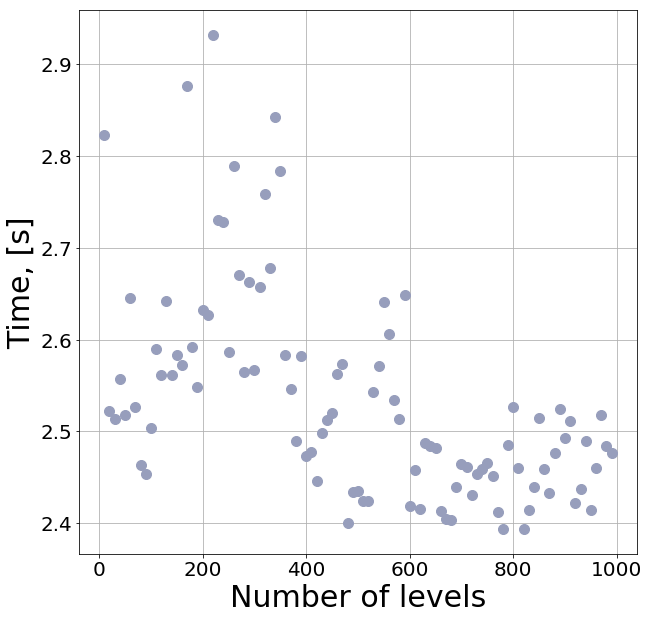

In [15]:
mycolor1 = (152/256,159/256,189/256)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(num_p,t,'o',color=mycolor1,markersize=10)

plt.tick_params(axis='x',which='both',labelsize=20)
plt.tick_params(axis='y',which='both',labelsize=20)
plt.xlabel('Number of levels',fontsize=30)
plt.ylabel('Time, [s]',fontsize=30)
plt.grid(True)
plt.locator_params(axis='x', nbins=6)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
mycolor1 = (152/256,159/256,189/256)
plt.figure(figsize=(10,10))
plt.plot(num_p,t,'o',color=mycolor1,markersize=10)

TypeError: unhashable type: 'numpy.ndarray'

# Simple 2 variable example to check distributions

In [ ]:
from SALib.sample import morris
from scipy.stats import lognorm, norm, triang
import numpy as np
import matplotlib.pyplot as plt
from constants import *

In [ ]:
n_vars = 2
names = ['x1','x2']
bounds = [[0,1],[0,7]]
problem = {
    'num_vars': n_vars,
    'names':    names,
    'bounds':   bounds
}
n_tra = 1000
p = 4
samples = morris.sample(problem, N=n_tra, num_levels=p)
N = samples.shape

In [ ]:
ind = 1
x = samples[:,ind]
#old uniform distribution
width = bounds[ind][1]-bounds[ind][0]
mycolor = (152/256,159/256,189/256)

In [ ]:
len(x)

In [ ]:
#1. Lognormal

#convert x to percentages q
q = [xx*SIX_SIGMA_Q/width+(1-SIX_SIGMA_Q)/2 for xx in x]
#new lognormal
mu = 0
sigma = 0.5
shift = 0
#Converted samples generated using ppf (=inverse of cdf)
y = lognorm.ppf(q,s=sigma,loc=shift,scale=np.exp(mu))

plt.figure(figsize=(20,10))
plt.hist(y,50,density=1,color=mycolor)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',right=False,left=False,labelleft=False)

In [ ]:
A = 8.6e-10 
B = 3.53
C = 4.5
x = 133000
y = A*x**B+C

In [ ]:
y/3600/24

In [ ]:
#2. Normal
#convert x to percentages q
q = [xx*SIX_SIGMA_Q/width+(1-SIX_SIGMA_Q)/2 for xx in x]
#ql = 0.0015
#qu = 0.9985
#q = [max(qq,ql) for qq in q]
#q = [min(qq,qu) for qq in q]
#new normal
mu = 0
sigma = 0.5 
#Converted samples generated using ppf (=inverse of cdf)
y = norm.ppf(q,loc=mu,scale=sigma)

fig = plt.hist(y,150,density=1)

In [ ]:
#3. Triangular
#convert x to percentages q
q = [xx/width for xx in x]
#new triangular
loc   = 0.01
scale = 0.11
c     = 0.9
#Converted samples generated using ppf (=inverse of cdf)
y = triang.ppf(q,c=c,loc=loc,scale=scale)

fig = plt.hist(y,150,density=1)

## 3. Run LCI and LCIA with tech_params with new samples

In [ ]:
#Create new vector "amounts" of size n_params but with new sampled values
amount = lca.tech_params['amount']
score = np.zeros(N)
i = 0
for x in samples:
    if not (i % 50):
        print(i)
    amount[all_triang['i']] = x
    lca.tech_params['amount'] = amount
    lca.rebuild_technosphere_matrix(lca.tech_params['amount'])
    lca.redo_lci()
    lca.redo_lcia()
    score[i] = lca.score
    i += 1

In [ ]:
#Create new vector "amounts" of size n_params but with new sampled values
amount = lca.tech_params['amount']
score = np.zeros(N)
i = 0
amount[all_triang['i']] = samples[90]
lca.tech_params['amount'] = amount
lca.rebuild_technosphere_matrix(lca.tech_params['amount'])
lca.redo_lci()
lca.redo_lcia()
#score[i] = lca.score
#i += 1
lca.score

In [ ]:
samples[90]

In [ ]:
from scipy.stats.distributions import norm

In [ ]:
norm?

In [ ]:
score

In [ ]:
from matplotlib.pyplot import hist

In [ ]:
hist()

In [ ]:
gurobipy.

# [12.10.2018] Elementary effect method

In [ ]:
def stats_array_2_salib(vec):
    """
    Function that converts uncertainty info from stats_array format to salib format
    
    stats_array format: https://stats-arrays.readthedocs.io/en/latest/index.html#params-array
    salib format: https://github.com/SALib/SALib/blob/master/SALib/util/__init__.py
    """
    
    #IDs from stats_array
    id_uniform = 4
    id_triang = 5
    id_normal = 3
    id_lognorm = 2
    
    #Uniform
    if vec['uncertainty_type'] == id_uniform:
        dists = ['unif', vec['minimum'], vec['maximum']]
    #Triangular
    elif vec['uncertainty_type'] == id_triang:
        width = vec['maximum']-vec['minimum']
        peak = (vec['loc']-vec['minimum'])/float(width)
        dists = ['triang', width, peak, vec['minimum']]
    #Normal
    elif vec['uncertainty_type'] == id_normal:
        dists = ['norm', vec['loc'], vec['scale']]
    #Lognormal
    elif ['uncertainty_type'] == id_lognorm:
        m = vec['loc']   #mean of the underlying normal distribution
        s = vec['scale'] #std  of the underlying normal distribution
        ln_mean = exp(m + s**2/2)
        ln_std = sqrt((exp(s**2)-1)*exp(2*m+s**2))
        dists = ['lognorm', ln_mean, ln_std]
    else:
        dists = []
        
    return dists
    

In [ ]:
def stats_array_2_salib_all(vecs):
    for x in vecs:
        #Create a dictionary with tech_params and uncertainty info on them
        if x[6] ~= 0:
            

In [ ]:
stats_array_2_salib(lca.tech_params[16026])

In [ ]:
s = 0
for i in range(lca.tech_params.shape[0]):
    #Create a dictionary with tech_params and uncertainty info on them
    if lca.tech_params[i][5] == 5:
        s+=1
print(s)

In [ ]:
lca.tech_params[16026][]

# For the given demand vector run Monte Carlo simulations

In [ ]:
import stats_arrays as st

In [ ]:
#First local MC, only change A[1,2681]
for j in range(len(act_lci.tech_params)):
    if ((act_lci.tech_params[j]["row"]==1) and (act_lci.tech_params[j]["col"]==2681)):
        break
index = j
A_1_2681 = act_lci.tech_params[index]
#Specify distribution parameters (as they are given by ecoinvent)
A_1_2681_params = {key:value for (key,value) in zip(A_1_2681.dtype.names,A_1_2681)}

In [ ]:
#random number generator
A_1_2681_gen = st.MCRandomNumberGenerator(st.UncertaintyBase.from_dicts(A_1_2681_params))

In [ ]:
#number of MC simulations
N = 10
samples = np.zeros(N)
supply  = np.zeros((N,act_lci.inventory.shape[0]))
for i in range(N):
    samples[i] = next(A_1_2681_gen)
    temp = copy.deepcopy(act_lci.tech_params[:]["amount"])
    temp[index] = samples[i]
    act_lci.rebuild_technosphere_matrix(temp)
    act_lci.redo_lci()
    supply[i,:] = np.sum(act_lci.inventory,axis=1).A1

In [ ]:
#First order sensitivity indices
si_first = np.var(samples)/np.var(supply)
#si_total = 

# Plotting for the LEA presentation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.figure(figsize=(20,10))
plt.plot(x,mlab.normpdf(x, mu, sigma),'black',linewidth=40.0)
plt.show()




In [ ]:

mu = 4
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(0.2, 10, 1000)

loc = 0.15
scale = 2
plt.figure(figsize=(20,10))
#plt.rcParams['axes.facecolor'] = (152/256,159/256,189/256)
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(x, lognorm.pdf(x, sigma, loc, scale),'black', lw=40)



In [ ]:
c= 0.25
x = np.linspace(0,1, 100)
plt.figure(figsize=(20,10))
plt.rcParams['axes.facecolor'] = 'white'
plt.plot(x, triang.pdf(x, c),'black', lw=40)

In [ ]:
#Scatter plots
mycolor = (105/256,118/256,158/256)

N = 200
x = np.arange(1,N+1)
y1 = np.random.randn(N)*250+range(1,N+1)
y2 = np.random.randn(N)*60+range(1,N+1)
y3 = np.random.randn(N)*20+range(1,N+1)
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',right=False,left=False,labelleft=False)
plt.xlabel('X1',fontsize=30)
plt.ylabel('Y',fontsize=30)
plt.plot( x,y1, linestyle='none', marker='o',markersize=10,mfc=mycolor,mec=mycolor)
plt.grid(True)

plt.subplot(132)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',right=False,left=False,labelleft=False)
plt.xlabel('X2',fontsize=30)
plt.ylabel('Y',fontsize=30)
plt.plot( x,y2, linestyle='none', marker='o',markersize=10,mfc=mycolor,mec=mycolor)
plt.grid(True)

plt.subplot(133)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',right=False,left=False,labelleft=False)
plt.xlabel('X3',fontsize=30)
plt.ylabel('Y',fontsize=30)
plt.plot( x,y3, linestyle='none', marker='o',markersize=10,mfc=mycolor,mec=mycolor)
plt.grid(True)


In [ ]:
plt.xlabel?

## Surface for EET

In [ ]:
y = lambda x1,x2: x1+20*x2-x1*x2^2

In [ ]:
x1 = np.arange(1,10,0.1)
x2 = np.arange(1,10,0.1)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

plt.figure(figsize=(20,5))
fig = plt.figure(figsize=(20, 10))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = X**3+20*Y-X*Y**2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(50,50)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',right=False,left=False,labelleft=False)
plt.tick_params(axis='z',which='both',right=False,left=False,labelleft=False)
ax.set_xlabel('X1',fontsize=30)
ax.set_ylabel('X2',fontsize=30)
ax.set_zlabel('Y',fontsize=30)

plt.show()
